<a href="https://colab.research.google.com/github/aziamimoh/redesigned-adventure/blob/main/Copy_of_BIOL123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install biopython
!pip install scikit-bio
!pip install networkx


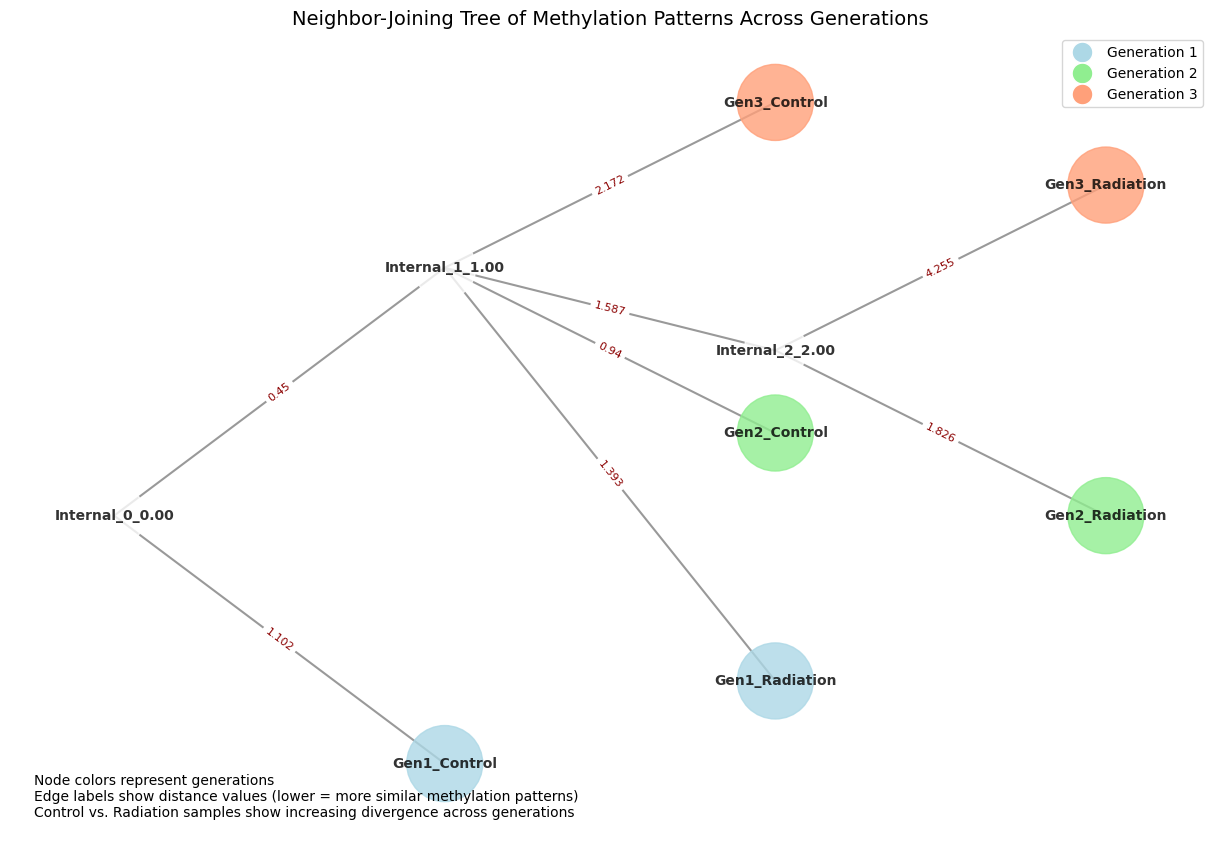

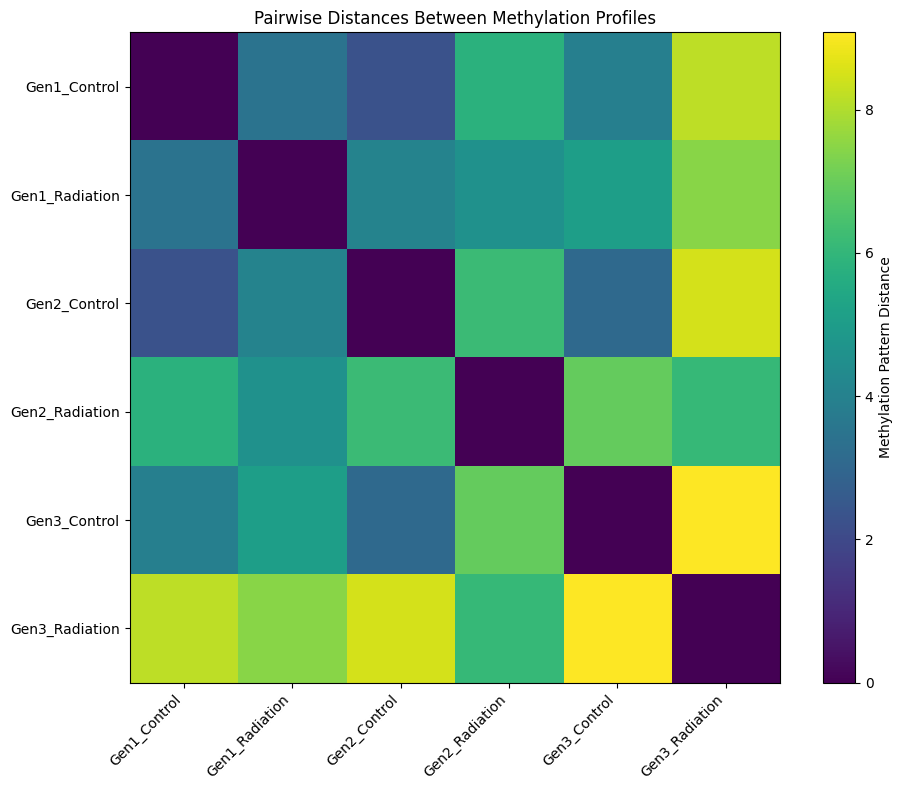

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
from skbio.tree import nj
from skbio import DistanceMatrix
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Generate mock data that represents methylation patterns
# 3 generations with 2 radiation treatments each
np.random.seed(42)

# Number of samples and features
n_generations = 3
n_treatments = 2  # Control and Radiation
n_samples = n_generations * n_treatments
n_features = 1000  # Number of methylation sites

sample_names = [
    "Gen1_Control", "Gen1_Radiation",
    "Gen2_Control", "Gen2_Radiation",
    "Gen3_Control", "Gen3_Radiation"
]

# Generate data (values between 0 and 1)
base_methylation = np.random.rand(1, n_features) * 0.5 + 0.25  # Base pattern

# control samples similar within generations
# radiation samples will diverge more with each generation
methylation_data = np.zeros((n_samples, n_features))

# Generation 1
methylation_data[0] = base_methylation + np.random.normal(0, 0.05, n_features)  # Control
methylation_data[1] = base_methylation + np.random.normal(0, 0.1, n_features)   # Radiation

# Generation 2 - inherits from Gen 1 with modifications
methylation_data[2] = methylation_data[0] + np.random.normal(0, 0.07, n_features)  # Control
methylation_data[3] = methylation_data[1] + np.random.normal(0, 0.15, n_features)  # Radiation

# Generation 3 - inherits from Gen 2 with more modifications
methylation_data[4] = methylation_data[2] + np.random.normal(0, 0.1, n_features)   # Control
methylation_data[5] = methylation_data[3] + np.random.normal(0, 0.2, n_features)   # Radiation

# Ensure values stay within range (0-1)
methylation_data = np.clip(methylation_data, 0, 1)

# Compute pairwise distances
distance_matrix_square = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        # Calculate distance between methylation profiles
        distance_matrix_square[i, j] = np.sqrt(np.sum((methylation_data[i] - methylation_data[j])**2))

# Create distance matrix with sample names
dist_matrix = DistanceMatrix(distance_matrix_square, sample_names)

# Apply Neighbor-Joining
tree = nj(dist_matrix)

# Step 4: Convert TreeNode to networkx graph with improved node handling
def add_edges(tree, graph, parent=None, depth=0, pos_dict=None, x_offset=0, y_offset=0, siblings=1, sibling_idx=0):
    """
    Recursively add edges to the graph from the TreeNode with better positioning.
    Returns the node name for reference.
    """
    # create a unique internal node ID if not tip/leaf node
    if tree.is_tip():
        node_name = tree.name
    else:
        node_name = f"Internal_{depth}_{x_offset:.2f}"

    graph.add_node(node_name, is_tip=tree.is_tip())

    if tree.is_tip():
        pos_dict[node_name] = (depth, y_offset)
    else:

        pos_dict[node_name] = (depth, y_offset)

    if parent is not None:
        branch_length = round(tree.length, 3) if tree.length else 0.0
        graph.add_edge(parent, node_name, length=branch_length)


    n_children = len(list(tree.children))
    if n_children > 0:
        child_y_spread = 1.0 / (n_children + 1)
        for i, child in enumerate(tree.children):

            child_y = y_offset + (i+1) * child_y_spread - 0.5
            add_edges(child, graph, node_name, depth+1, pos_dict, x_offset+1, child_y, n_children, i)

    return node_name


G = nx.Graph()
pos_dict = {}

root_node = add_edges(tree, G, None, 0, pos_dict)

#plotting
plt.figure(figsize=(12, 8))

node_colors = []
for node in G.nodes():
    if G.nodes[node]['is_tip']:
        if 'Gen1' in node:
            node_colors.append('lightblue')
        elif 'Gen2' in node:
            node_colors.append('lightgreen')
        elif 'Gen3' in node:
            node_colors.append('lightsalmon')
        else:
            node_colors.append('lightgrey')
    else:
        node_colors.append('white')  # Internal node

node_sizes = []
for node in G.nodes():
    if G.nodes[node]['is_tip']:
        node_sizes.append(3000)  # Larger for tip/leaf
    else:
        node_sizes.append(2000)  # Smaller for internal nodes

#labels
nx.draw(G, pos=pos_dict, with_labels=True, font_weight='bold',
        node_color=node_colors, edge_color='gray',
        node_size=node_sizes, font_size=10,
        width=1.5, alpha=0.8)


edge_labels = nx.get_edge_attributes(G, 'length')
nx.draw_networkx_edge_labels(G, pos=pos_dict, edge_labels=edge_labels,
                             font_size=8, font_color='darkred')


plt.title('Neighbor-Joining Tree of Methylation Patterns Across Generations', fontsize=14)

#legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=15, label='Generation 1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15, label='Generation 2'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightsalmon', markersize=15, label='Generation 3')
]
plt.legend(handles=legend_elements, loc='best')


plt.figtext(0.02, 0.02,
           "Node colors represent generations\n"
           "Edge labels show distance values (lower = more similar methylation patterns)\n"
           "Control vs. Radiation samples show increasing divergence across generations",
           fontsize=10)


plt.axis('off')


#plt.tight_layout()
plt.show()

#heatmap
plt.figure(figsize=(10, 8))
plt.imshow(distance_matrix_square, cmap='viridis')
plt.colorbar(label='Methylation Pattern Distance')
plt.xticks(range(len(sample_names)), sample_names, rotation=45, ha='right')
plt.yticks(range(len(sample_names)), sample_names)
plt.title('Pairwise Distances Between Methylation Profiles')
plt.tight_layout()
plt.show()

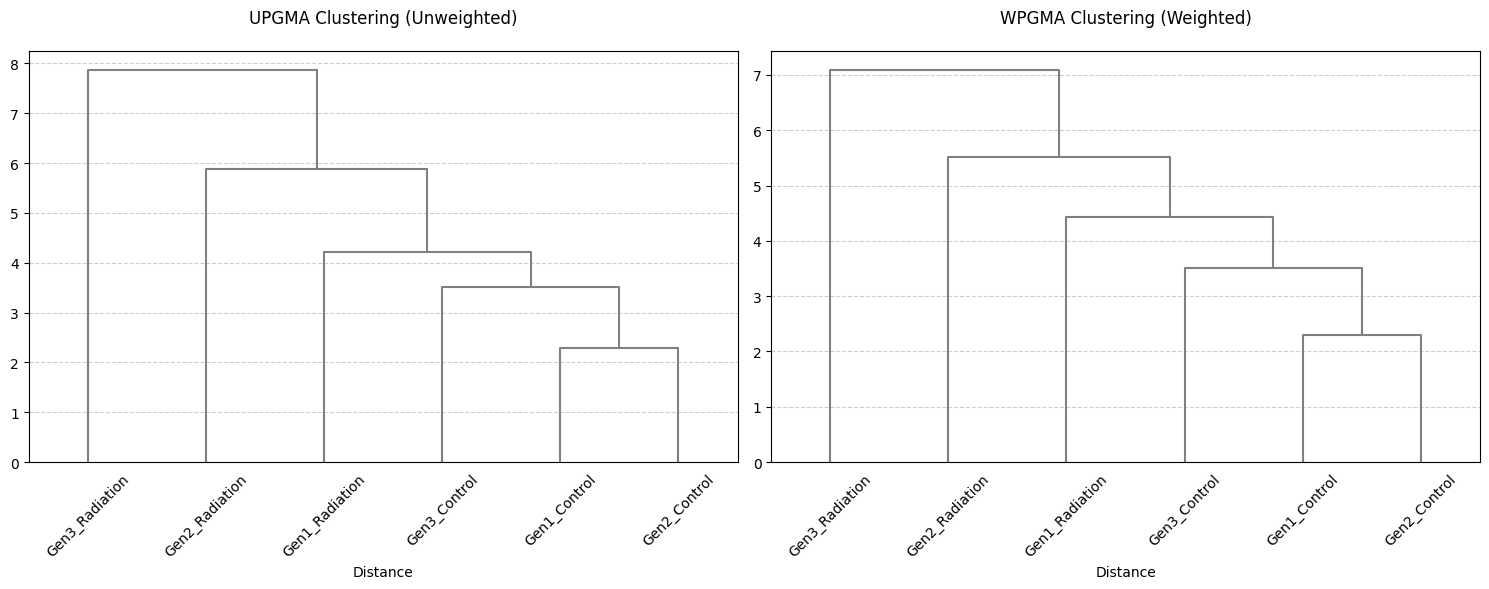


Distance Matrix:
                Gen1_Control  Gen1_Radiation  Gen2_Control  Gen2_Radiation  \
Gen1_Control            0.00            3.47          2.30            5.80   
Gen1_Radiation          3.47            0.00          4.08            4.59   
Gen2_Control            2.30            4.08          0.00            6.18   
Gen2_Radiation          5.80            4.59          6.18            0.00   
Gen3_Control            3.92            5.10          3.11            6.93   
Gen3_Radiation          8.18            7.46          8.51            6.08   

                Gen3_Control  Gen3_Radiation  
Gen1_Control            3.92            8.18  
Gen1_Radiation          5.10            7.46  
Gen2_Control            3.11            8.51  
Gen2_Radiation          6.93            6.08  
Gen3_Control            0.00            9.08  
Gen3_Radiation          9.08            0.00  


In [11]:
#code from above
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from skbio import DistanceMatrix
from skbio.tree import nj
import networkx as nx
from matplotlib.lines import Line2D

#Data generation using code from above
np.random.seed(42)

# Number of samples and features
n_generations = 3
n_treatments = 2  # Control and Radiation
n_samples = n_generations * n_treatments
n_features = 1000  # Number of methylation sites


sample_names = [
    "Gen1_Control", "Gen1_Radiation",
    "Gen2_Control", "Gen2_Radiation",
    "Gen3_Control", "Gen3_Radiation"
]

# Generate methylation data
base_methylation = np.random.rand(1, n_features) * 0.5 + 0.25  # Base pattern
methylation_data = np.zeros((n_samples, n_features))

# Generation 1
methylation_data[0] = base_methylation + np.random.normal(0, 0.05, n_features)  # Control
methylation_data[1] = base_methylation + np.random.normal(0, 0.1, n_features)   # Radiation

# Generation 2
methylation_data[2] = methylation_data[0] + np.random.normal(0, 0.07, n_features)  # Control
methylation_data[3] = methylation_data[1] + np.random.normal(0, 0.15, n_features)  # Radiation

# Generation 3
methylation_data[4] = methylation_data[2] + np.random.normal(0, 0.1, n_features)   # Control
methylation_data[5] = methylation_data[3] + np.random.normal(0, 0.2, n_features)   # Radiation

methylation_data = np.clip(methylation_data, 0, 1)

# Compute pairwise distances
distance_matrix_square = np.zeros((n_samples, n_samples))
for i in range(n_samples):
    for j in range(n_samples):
        distance_matrix_square[i, j] = np.sqrt(np.sum((methylation_data[i] - methylation_data[j])**2))

# Convert to condensed distance matrix
distance_matrix = squareform(distance_matrix_square, checks=False)

upgma_result = linkage(distance_matrix, method='average')
wpgma_result = linkage(distance_matrix, method='weighted')

# Plot
plt.figure(figsize=(15, 6))

# UPGMA
plt.subplot(1, 2, 1)
dendrogram(upgma_result,
           labels=sample_names,
           orientation='top',
           leaf_rotation=45,
           leaf_font_size=10,
           color_threshold=0,
           above_threshold_color='gray')
plt.title("UPGMA Clustering (Unweighted)", pad=20, fontsize=12)
plt.xlabel("Distance", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# WPGMA
plt.subplot(1, 2, 2)
dendrogram(wpgma_result,
           labels=sample_names,
           orientation='top',
           leaf_rotation=45,
           leaf_font_size=10,
           color_threshold=0,
           above_threshold_color='gray')
plt.title("WPGMA Clustering (Weighted)", pad=20, fontsize=12)
plt.xlabel("Distance", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Print distance matrix
print("\nDistance Matrix:")
print(pd.DataFrame(distance_matrix_square, columns=sample_names, index=sample_names).round(2))





It turns out I couldn't graph them the same way because I used pre-built functions for UPGMA/WPGMA, while for Neighbor-Joining I had to manually handle the nodes and branches.
